In [7]:
import numpy as np
import time
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.datasets import load_sample_image

In [8]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [9]:
X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test  = X_test.reshape(-1, 1, 28, 28)  / 255.0
Y_train = tf.keras.utils.to_categorical(Y_train).T
Y_test  = tf.keras.utils.to_categorical(Y_test).T

In [10]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

# Expects the filters to be a 4-D ndarray (N-filters, Channels, Height, Width)
# Expects the image to be a 4-D ndarray (ImageIdx, Channels, Height, Width)
def convolve(image, filters, stride = 1, mode = 'valid'):
    n_img = image.shape[0]
    c_img = image.shape[1]
    img_h = image.shape[2]
    img_w = image.shape[3]    
    
    filter_c = filters.shape[1]
    filter_h = filters.shape[2]
    filter_w = filters.shape[3]

    assert filter_c == c_img, 'Each filter must have the same number of channels as the image ({} != {})'.format(filter_c, c_img)

    final_batch = image

    if mode == 'same':
        pad_x  = int(np.ceil((stride * (img_w - 1) - img_w + filter_w) / 2.0))
        pad_y  = int(np.ceil((stride * (img_h - 1) - img_h + filter_h) / 2.0))
        padded = np.zeros((n_img, c_img, img_h + pad_y * 2, img_w + pad_x * 2))

        padded[:, :, pad_y:img_h+pad_y, pad_x:img_w+pad_x ] = image
        final_batch = padded

    out_h = (final_batch.shape[2] - filter_h) // stride + 1
    out_w = (final_batch.shape[3] - filter_w) // stride + 1
    
    
    stride_i = final_batch.strides[0]
    stride_c = 0 if c_img == 1 else final_batch.strides[1]
    stride_y = final_batch.strides[2]
    stride_x = final_batch.strides[3]

    strides  = (stride_i, stride_c, stride_y * stride, stride_x * stride, stride_y, stride_x)

    windows  = np.lib.stride_tricks.as_strided(
        final_batch,
        shape   = (n_img, c_img, out_h, out_w, filter_h, filter_w),
        strides = strides,
    )
    conv = np.einsum('xchwij,fcij->xfhw', windows, filters)
    return conv

def conv_pool(image, size, stride = 2, type = 'avg'):
    n_img = image.shape[0]
    c_img = image.shape[1]
    img_h = image.shape[2]
    img_w = image.shape[3]

    assert type in ['max', 'avg'], "Please select either 'max' or 'avg' for the pooling operation"

    out_h = (img_h - size) // stride + 1
    out_w = (img_w - size) // stride + 1

    stride_i = image.strides[0]
    stride_c = image.strides[1]
    stride_y = image.strides[2]
    stride_x = image.strides[3]

    strides  = (stride_i, stride_c, stride_y * stride, stride_x * stride, stride_y, stride_x)
    windows  = np.lib.stride_tricks.as_strided(
        image,
        shape   = (n_img, c_img, out_h, out_w, size, size),
        strides = strides
    )

    if type == 'max':
        pooled = np.max(windows, axis = (4, 5))
    else:
        pooled = np.average(windows, axis = (4, 5))
        
    return pooled


In [11]:
learning_rate = 1e-3

class ConvLayer:
    def __init__(self, n_filters, filter_sz, stride = 1, mode = 'valid'):
        self.n_filters  = n_filters
        self.filter_sz  = filter_sz
        self.stride     = stride
        self.mode       = mode

        self.filters    = None
        self.biases     = np.zeros((self.n_filters, 1))

        self.dL_dfilter = None
        self.dL_dbiases = None

    def forward(self, input_batch):
        self.input_batch = input_batch

        if self.filters is None:
            img_channels = self.input_batch.shape[1]
            self.filters = np.random.randn(self.n_filters, img_channels, self.filter_sz, self.filter_sz) / np.sqrt(self.filter_sz ** 2)

        self.z_out = convolve(input_batch, self.filters, self.stride, self.mode)
        self.z_out = np.repeat(np.expand_dims(self.biases, axis = (0, 2)), self.z_out.shape[0], axis = 0) + self.z_out
        self.a_out = np.maximum(0, self.z_out)

        return self.a_out
    
    def backward(self, dA):
        
        self.dZ    = dA * (self.z_out > 0.0)
        batch_size = self.dZ.shape[0]
        self.dZ    = np.sum(self.dZ, axis = 0).reshape(-1, 1, *self.dZ.shape[-2::])
        self.dW    = np.sum(convolve(self.input_batch, self.dZ, self.stride, 'valid'), axis = 0, keepdims=True) / batch_size
        self.dW    = np.einsum('cfhw->fchw', self.dW)
        self.dB    = np.sum(self.dZ, axis = (1, 2, 3)).reshape(-1, 1) / batch_size

        self.filters -= learning_rate * self.dW
        self.biases  -= learning_rate * self.dB
        #print(self.dW.shape, self.filters.shape, self.dB.shape, self.biases.shape)

class PoolLayer:
    def __init__(self, filter_sz, stride = 2, pool_op = 'max'):
        self.filter_sz = filter_sz
        self.stride    = stride
        self.mode      = pool_op

    def forward(self, input_batch):
        self.input_batch = input_batch
        self.a_out = conv_pool(input_batch, self.filter_sz, self.stride, self.mode)

        return self.a_out

    def backward(self, dZ):
        if self.mode == 'avg':
            self.dZ_next = np.full(self.input_batch.shape, 1.0 / (self.filter_sz ** 2))
            self.dZ_next *= np.tile(dZ, (1, 1, self.stride, self.stride))
        else:
            self.max     = np.tile(self.a_out, (1, 1, self.stride, self.stride))
            self.dZ_next = (self.input_batch >= self.max) * np.tile(dZ, (1, 1, self.stride, self.stride))
        return self.dZ_next


class FlattenLayer:
    def __init__(self):
        pass

    def forward(self, input_batch):
        self.orig_shape = input_batch.shape
        self.z_out = input_batch.reshape(self.orig_shape[0], -1).T
        return self.z_out

    def backward(self, dZ):
        self.dZ_next = dZ.reshape(self.orig_shape)
        return self.dZ_next

class DenseLayer:
    def __init__(self, n_units, activation, is_output):
        self.n_units    = n_units
        self.activation = activation

        self.weights    = None
        self.biases     = np.zeros((self.n_units, 1))
        self.is_output  = is_output

    def forward(self, input_batch):
        self.input_batch = input_batch
        self.batch_size  = input_batch.shape[1]

        if self.weights is None:
            num_input    = self.input_batch.shape[0]
            self.weights = np.random.randn(self.n_units, num_input) / np.sqrt(num_input)
        
        self.z_out  = np.dot(self.weights, self.input_batch) + self.biases
        self.z_out -= self.z_out.max()
        self.a_out  = np.exp(self.z_out) / np.sum(np.exp(self.z_out), axis = 0)

        return self.a_out

    def backward(self, dZ):
        self.dZ = dZ
        self.dW = np.dot(self.dZ, self.input_batch.T) / self.batch_size
        self.db = np.sum(self.dZ, axis = 1, keepdims = True) / self.batch_size

        self.dZ_next = np.dot(self.weights.T, self.dZ)

        self.weights -= learning_rate * self.dW
        self.biases  -= learning_rate * self.db
        return self.dZ_next

In [12]:
conv1  = ConvLayer(n_filters = 100, filter_sz = 5, stride = 1, mode = 'same')
flat1  = FlattenLayer()
pool1  = PoolLayer(2, 2, 'max')
dense1 = DenseLayer(n_units = 10, activation = 'softmax', is_output = True)

n_epoch = 2

TOTAL_SZ  = 6000
BATCH_SZ  = 50

X_batches = np.array(np.split(X_train[:TOTAL_SZ], TOTAL_SZ / BATCH_SZ, axis = 0))
Y_batches = np.array(np.split(Y_train[:, :TOTAL_SZ], TOTAL_SZ / BATCH_SZ, axis = 1))
losses    = []
accuracy  = []
for epoch in range(n_epoch):
    for batch_idx in range(TOTAL_SZ // BATCH_SZ):
        
        batch_X = X_batches[batch_idx]
        batch_Y = Y_batches[batch_idx]

        forward_out  = conv1.forward(batch_X)
        forward_out  = pool1.forward(forward_out)
        forward_out  = flat1.forward(forward_out)
        forward_out  = dense1.forward(forward_out)
        
        loss = -(batch_Y * np.log(forward_out + 1e-5) + (1 - batch_Y) * np.log(1 - forward_out + 1e-5))
        loss = np.sum(loss, axis = 0)
        cost = np.average(loss)
        
        acc  = np.average(np.argmax(forward_out, axis = 0) == np.argmax(batch_Y, axis = 0))

        losses.append(cost)
        accuracy.append(acc)

        backward_out = forward_out - batch_Y
        backward_out = dense1.backward(backward_out)
        backward_out = flat1.backward(backward_out)
        backward_out = pool1.backward(backward_out)
        backward_out = conv1.backward(backward_out)

        progress_batch = batch_idx / X_batches.shape[0]
        progress_bar   = ('=' * (math.ceil(progress_batch * 30)))
        progress_bar   = progress_bar + (' ' * (30 - len(progress_bar)))
        output_string  = 'epoch: [{:2}/{:2}] [{}] - loss: {:.4f} - accuracy: {:.4f}'.format(epoch+1, n_epoch, progress_bar, cost, acc)
        print(output_string, end = '\r')
    print()

epoch: [ 1/ 2] [==============================] - loss: 1.7324 - accuracy: 0.8800
epoch: [ 2/ 2] [==============================] - loss: 1.2533 - accuracy: 0.9200


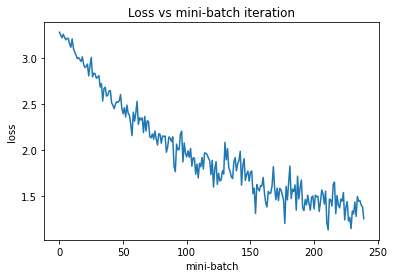

In [13]:
plt.title('Loss vs mini-batch iteration')
plt.xlabel('mini-batch')
plt.ylabel('loss')
plt.plot(losses)

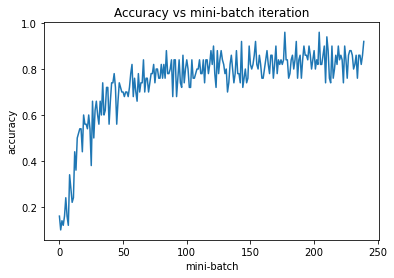

In [14]:
plt.title('Accuracy vs mini-batch iteration')
plt.xlabel('mini-batch')
plt.ylabel('accuracy')
plt.plot(accuracy)

In [15]:
forward_out  = conv1.forward(X_test)
forward_out  = pool1.forward(forward_out)
forward_out  = flat1.forward(forward_out)
forward_out  = dense1.forward(forward_out)
print('Test accuray: {:.4f}'.format(np.average(np.argmax(forward_out, axis = 0) == np.argmax(Y_test, axis = 0))))

Test accuray: 0.8360
